In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
nx = 81
dx = 0.25
dt = 0.0002
gamma = 1.4
L = 20
minx = -10
maxx = 10
ncells=L/dx
x = np.linspace(minx, maxx, num=nx)

In [3]:
# Build IC
rho0 = np.zeros(nx)
v0 = np.zeros(nx)
p0 = np.zeros(nx)
mid = int(ncells/2)

In [4]:
p0[:mid] = 100000.0
p0[mid:] = 10000
v0[:mid] = 0.0
v0[mid:] = 0.0
rho0[:mid] = 1.0
rho0[mid:] = 0.125

In [5]:
tfinal = 0.01 #s
nt = int(tfinal/dt)
nt

50

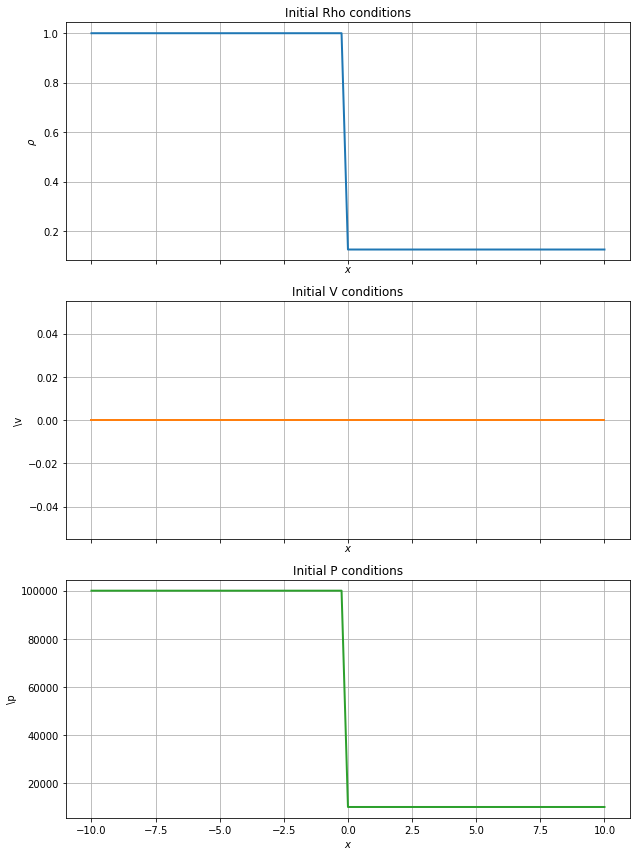

In [6]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True)

ax0.set_title('Initial Rho conditions')
ax0.set_ylabel(r'$\rho$')
ax0.set_xlabel(r'$x$')
ax0.plot(x, rho0,color='C0', linestyle='-', linewidth=2)[0]

ax0.grid()

ax1.set_title('Initial V conditions')
ax1.set_ylabel(r'\v')
ax1.set_xlabel(r'$x$')
ax1.plot(x, v0,color='C1', linestyle='-', linewidth=2)[0]

ax1.grid()

ax2.set_title('Initial P conditions')
ax2.set_ylabel(r'\p')
ax2.set_xlabel(r'$x$')
ax2.plot(x, p0,color='C2', linestyle='-', linewidth=2)[0]

ax2.grid()

fig.set_size_inches(9,12)
plt.tight_layout()

In [7]:
u1 = rho0
u2 = rho0*v0
u3 = p0/(gamma-1)+1/2*rho0*v0**2
u0 = np.array([u1,u2,u3])


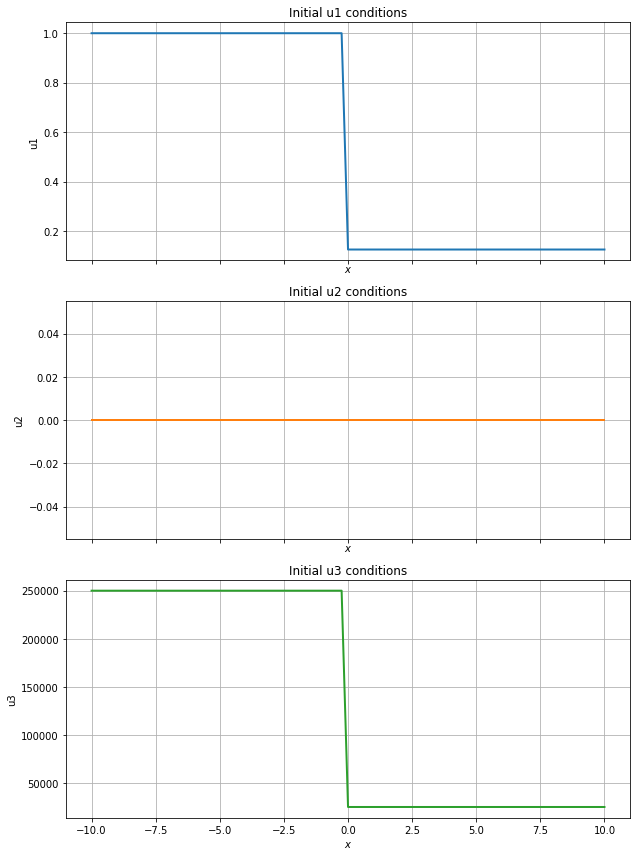

In [8]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True)

ax0.set_title('Initial u1 conditions')
ax0.set_ylabel(r'u1')
ax0.set_xlabel(r'$x$')
ax0.plot(x, u1,color='C0', linestyle='-', linewidth=2)[0]

ax0.grid()

ax1.set_title('Initial u2 conditions')
ax1.set_ylabel(r'u2')
ax1.set_xlabel(r'$x$')
ax1.plot(x, u2,color='C1', linestyle='-', linewidth=2)[0]

ax1.grid()

ax2.set_title('Initial u3 conditions')
ax2.set_ylabel(r'u3')
ax2.set_xlabel(r'$x$')
ax2.plot(x, u3,color='C2', linestyle='-', linewidth=2)[0]

ax2.grid()

fig.set_size_inches(9,12)
plt.tight_layout()

In [9]:
def flux(u,gamma):
    """
    Returns the right-hand side of the phugoid system of equations.
    Returns
    -------
    rhs : numpy.ndarray
    """
    u1,u2,u3 = u
    
    F = np.array([u2,
                    u2**2/u1+(gamma-1)*(u3-1/2*u2**2/u1),
                    (u3+(gamma-1)*(u3-1/2*u2**2/u1))*u2/u1])
    return F
    

In [10]:
def richtmyer(u0, nt, dt, dx, *args):
    """
    Computes the traffic density on the road 
    at a certain time given the initial traffic density.
    Integration using MacCormack scheme.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_values : 2-tuple of floats
        The value of the density at the first and last locations.
    args : list or tuple
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road.
    """
        
    u_hist = [u0.copy()]
    u = u0.copy()
    
    
    for n in range(nt):
        # Compute the flux.
        F = flux(u, *args)
        Fjm = F[:,:-2] #F(rho(j-1))
        Fj = F[:,1:-1] #F(rho(j))
        Fjp = F[:,2:]  #F(rho(j+1))
        
        # Predictor step of the MacCormack scheme.
        ujm = u[:,:-2].copy() #rho(j-1)
        uj = u[:,1:-1].copy() #rho(j)
        ujp = u[:,2:].copy() #rho(j+1)
        
        up_p = 1/2*(ujp+uj)-dt/(2*dx)*(Fjp-Fj)
        up_m = 1/2*(uj+ujm)-dt/(2*dx)*(Fj-Fjm)
        # Compute the flux.
        Fm = flux(up_m, *args)
        Fp = flux(up_p, *args)
        # Corrector step of the Richtmyer scheme.
        u[:,1:-1] = u[:,1:-1]-dt/dx*(Fp-Fm)
        # Set the value at the first location.
        u[:,0] = u0[:,0]
        # Set the value at the last location.
        u[:,-1] = u0[:,-1]
        # Record the time-step solution.
        u_hist.append(u.copy())
    return u_hist

In [11]:
u_hist = richtmyer(u0,nt,dt,dx,gamma)

In [12]:
rho_f = u_hist[-1][0]
v_f = u_hist[-1][1]/u_hist[-1][0]
p_f = (gamma-1)*(u_hist[-1][2]-1/2*u_hist[-1][1]**2/u_hist[-1][0])

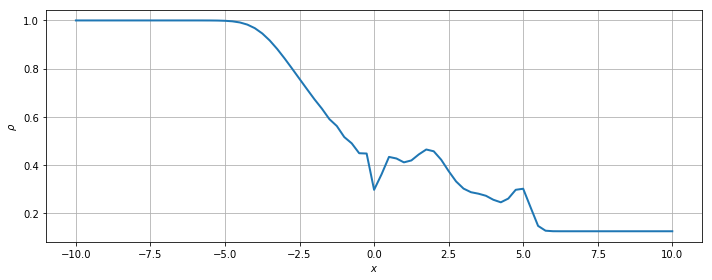

In [13]:
# Plot the initial traffic density.
fig = plt.figure(figsize=(10.0, 4.0))
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
plt.grid()
line = plt.plot(x, rho_f,
                   color='C0', linestyle='-', linewidth=2)[0]
#plt.xlim(0.0, L)
#plt.ylim(4.0, 11.0)
plt.tight_layout()

In [14]:
from matplotlib import animation
from IPython.display import HTML

In [15]:
def update_plot(n, u_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(u_hist[n][0])

In [16]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(u_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

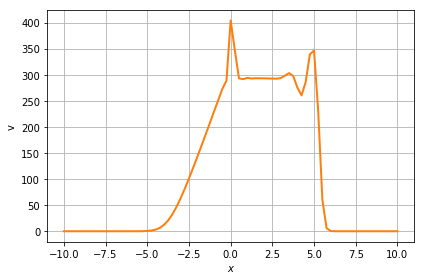

In [17]:
# Plot the initial traffic density.
fig = plt.figure(figsize=(6.0, 4.0))
plt.xlabel(r'$x$')
plt.ylabel(r'v')
plt.grid()
line = plt.plot(x, v_f,
                   color='C1', linestyle='-', linewidth=2)[0]
#plt.xlim(0.0, L)
#plt.ylim(4.0, 11.0)
plt.tight_layout()

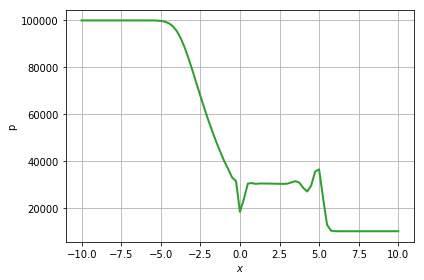

In [18]:
# Plot the initial traffic density.
fig = plt.figure(figsize=(6.0, 4.0))
plt.xlabel(r'$x$')
plt.ylabel(r'p')
plt.grid()
line = plt.plot(x, p_f,
                   color='C2', linestyle='-', linewidth=2)[0]
#plt.xlim(0.0, L)
#plt.ylim(4.0, 11.0)
plt.tight_layout()

In [19]:
x_index =int(np.where(x==2.5)[0])
x_index

50

In [20]:
print("Density at x=2.5; Rho={:.2f} kg/m^3".format(rho_f[x_index]))

Density at x=2.5; Rho=0.37 kg/m^3


In [21]:
print("Pressure at x=2.5; P={:.2f} N/m^2".format(p_f[x_index]))


Pressure at x=2.5; P=30250.89 N/m^2


In [22]:
print("Velocity at x=2.5; V={:.2f} m/s".format(v_f[x_index]))

Velocity at x=2.5; V=292.61 m/s
